In [ ]:
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Input, concatenate
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras import backend as K
import pandas as pd

In [ ]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

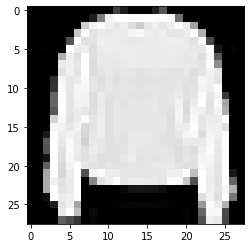

In [ ]:
plt.imshow(x_train[7].reshape(28,28))
plt.gray()

In [ ]:
x_train[0]

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


In [ ]:
input_shape=(784, )
emb_size = 128

def Build_network(input):
  model = Sequential()
  model.add(Dense(512, activation='relu', input_shape=input_shape))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(emb_size, activation='relu'))

  model.summary()
  return model

network=Build_network(input_shape)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
Total params: 566,144
Trainable params: 566,144
Non-trainable params: 0
_________________________________________________________________


In [ ]:
anchor_input = Input(input_shape)
positive_input = Input(input_shape)
negative_input = Input(input_shape)

anchor_vec = network(anchor_input)
positive_vec = network(positive_input)
negative_vec = network(negative_input)

output = concatenate([anchor_vec, positive_vec, negative_vec] , axis=-1)
triplet_network = Model([anchor_input,positive_input,negative_input] , output)
triplet_network.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 128)          566144      input_13[0][0]                   
                                                                 input_14[0][0]        

In [ ]:
x_train.shape[0]

60000

In [ ]:
def Generate_triplets(batch_size):
  anchors = np.zeros((batch_size,784))
  positives = np.zeros((batch_size,784))
  negatives = np.zeros((batch_size,784))
  total_size = x_train.shape[0] - 1

  for i in range(batch_size):
    random_index = np.random.randint(0, total_size)
    x_anchor = x_train[random_index]
    y_anchor = y_train[random_index]

    index_positive = np.squeeze(np.where(y_train==y_anchor))
    index_negative = np.squeeze(np.where(y_train!=y_anchor))

    x_positive = x_train[index_positive[np.random.randint(0,len(index_positive)-1)]]
    x_negative = x_train[index_negative[np.random.randint(0,len(index_negative)-1)]]

    anchors[i] = x_anchor
    positives[i] = x_positive
    negatives[i] = x_negative


  return[anchors,positives,negatives]

def Plot_triplets(samples):
  plt.figure(figsize=(6,6))
  y= np.asarray(samples)
  y= np.reshape(y, (3,batch_size,28,28))
  for j in range (batch_size):
    for i in range (3):
      plt.subplot(batch_size,3,i+1)
      plt.imshow(y[i][j,:,:])
    plt.show()

(3, 2, 784)


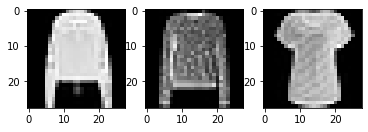

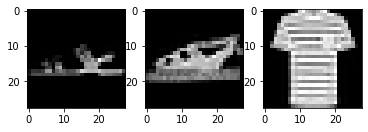

<Figure size 432x288 with 0 Axes>

In [ ]:
batch_size=2
samples = Generate_triplets(batch_size)
print(np.shape(samples))
Plot_triplets(samples)
plt.gray()

In [ ]:
alpha = 0.2
def Triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    p_dist = K.sum(K.square(anchor-positive), axis=-1)
    n_dist = K.sum(K.square(anchor-negative), axis=-1)
    return K.sum(K.maximum(p_dist - n_dist + alpha, 0), axis=0)  

In [ ]:
batch_size = 256
def Data_generator(batch_size):
    while True:
        x = Generate_triplets(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [ ]:
epochs = 20
batch_size=2048
steps_per_epoch = int(x_train.shape[0]/batch_size)
print(steps_per_epoch)
triplet_network.compile(loss=Triplet_loss, optimizer='adam')



29


In [ ]:
triplet_network.fit(
    Data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=1
)

Epoch 1/20
29/29 [==============================] - 33s 1s/step - loss: 127.5856
Epoch 2/20
29/29 [==============================] - 33s 1s/step - loss: 68.6560
Epoch 3/20
29/29 [==============================] - 33s 1s/step - loss: 57.3820
Epoch 4/20
29/29 [==============================] - 33s 1s/step - loss: 51.6262
Epoch 5/20
29/29 [==============================] - 33s 1s/step - loss: 51.3397
Epoch 6/20
29/29 [==============================] - 33s 1s/step - loss: 45.6136
Epoch 7/20
29/29 [==============================] - 33s 1s/step - loss: 43.8745
Epoch 8/20
29/29 [==============================] - 33s 1s/step - loss: 40.4401
Epoch 9/20
29/29 [==============================] - 33s 1s/step - loss: 39.8515
Epoch 10/20
29/29 [==============================] - 33s 1s/step - loss: 37.7404
Epoch 11/20
29/29 [==============================] - 33s 1s/step - loss: 36.3677
Epoch 12/20
29/29 [==============================] - 33s 1s/step - loss: 36.3377
Epoch 13/20
29/29 [=================

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
prediction = network.predict(x_test.reshape(10000,784))

In [ ]:
pca_out = PCA(n_components=2).fit_transform(prediction)

[]

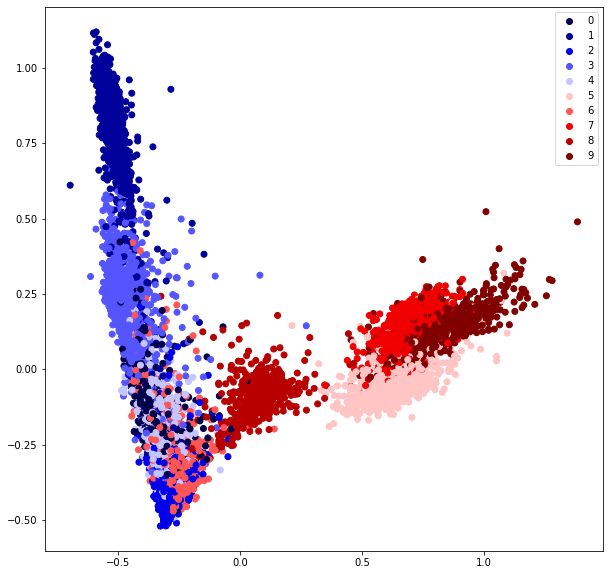

In [ ]:
plt.figure(figsize=(10,10))
label=['0','1','2','3','4','5','6','7','8','9']
label=[0,1,2,3,4,5,6,7,8,9]
scatter = plt.scatter(pca_out[:,0], pca_out[:,1], c=y_test, cmap='seismic',label=label)
plt.legend(handles=scatter.legend_elements()[0], labels=label)

plt.plot()

In [ ]:
network.save_weights('/content/drive/My Drive/FMNISTweights.h5')

In [ ]:
def compute_dist(a,b):
    a=a.reshape(-1,1)
    b=b.reshape(-1,1)
    #return np.sum(np.square(a-b))
    #return (np.sqrt(np.sum(np.square(a-b))))
    d = np.matmul(np.transpose(a), b)
    e = np.matmul(np.transpose(a), a)
    f = np.matmul(np.transpose(b), b)
    return (1 - (d / (np.sqrt(e) * np.sqrt(f))))

In [ ]:
def find_dist_test(ref,images):
    X1 = np.asarray(images)
    nb_images,_=np.shape(X1)
    test_array=np.zeros((1,nb_images))
    for i in range(nb_images):
        dist = compute_dist(ref,images[i])

        test_array[0,i]=dist
    return test_array

In [ ]:
distance=find_dist_test(prediction[8],prediction)

In [ ]:
distance_df = pd.DataFrame(distance,columns=[y_test],index={'Test Input'})


In [ ]:
distance_df

,9,2,1,1,6,1,4,6,5,7,4,5,7,3,4,1,2,4,8,0,2,5,7,9,1,4,6,0,9,3,8,8,3,3,8,0,7,5,7,9,...,1,6,6,4,9,1,4,9,7,8,2,6,2,9,7,8,5,6,9,6,0,0,8,1,3,2,7,5,8,4,5,6,8,9,1,9,1,8,1,5
Test Input,0.15348,1.0,0.887443,0.87661,1.0,0.878535,1.0,1.0,0.0,0.239713,1.0,0.030592,0.150331,0.929977,0.923464,0.856957,0.997464,0.986271,0.632895,1.0,0.955869,0.030134,0.274977,0.120321,0.861557,1.0,1.0,0.999971,0.324798,0.870028,0.625111,0.640193,0.792392,0.95481,0.611329,0.994542,0.267954,0.016296,0.260845,0.382869,...,0.882591,0.954677,0.958039,1.0,0.310409,0.865389,0.936047,0.24522,0.293216,0.436789,1.0,1.0,1.0,0.336147,0.340409,0.64978,0.015788,0.999803,0.325524,1.0,1.0,0.981462,0.623326,0.873233,1.0,0.741334,0.259799,0.030833,0.485832,0.999815,0.030003,0.992159,0.636762,0.392001,0.87048,0.338628,0.886842,0.671001,0.822803,0.027116


In [ ]:

y_test[0:20]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0],
      dtype=uint8)

In [ ]:
y_test.shape

(10000,)